<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_Fully_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
!pip install "jedi>=0.16"
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"

Matplotlib backend: Agg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.6 MB/s eta 0:00:00


In [2]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 673 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (166/166), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [9]:
# -*- coding: utf-8 -*-
"""Meander-driven launch pads: pads auto-attach to the meander start/end ties.

MODIFIED V2: Removes straight lead/buffer sections AND places pads correctly
             at the actual start/end points of the drawn meander lobes.

What this cell does
-------------------
• Calculates overall geometry parameters based on conceptual full path (incl. leads/buffers).
• Determines the actual start coordinate of the first meander lobe.
• Creates path objects containing ONLY the meandering lobes starting from that coordinate.
• Determines the actual end coordinate of the last meander lobe from the path.
• If LAUNCHPADS_ACTIVE, places LaunchpadWirebond pads so their "tie" pins align
  with the actual start and end coordinates of the drawn meander lobes.
• Converts ONLY the meander lobes and the launch pads to polygons.
• Writes the final geometry (lobes + correctly placed pads) to GDS.
"""

from __future__ import annotations

import math
import os
import warnings
from typing import Literal, Optional, Tuple, List

# Headless-safe for Colab/servers
os.environ["QT_QPA_PLATFORM"] = "offscreen"

# ----------------------------- Dependencies -----------------------------
try:
    import gdstk  # ≥ 0.9.5
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdstk>=0.9.5"])
    import gdstk

try:
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "shapely>=1.8"])
    from shapely.geometry import Polygon as ShpPolygon, MultiPolygon as ShpMultiPolygon

try:
    # Ensure necessary modules are imported after potential headless patching
    from qiskit_metal.designs import DesignPlanar
    from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
    from qiskit_metal.toolbox_metal import parse_value # Use official parser if available
    QM_AVAILABLE = True
except Exception as e:
    print(f"[Warn] Qiskit Metal import failed (may be expected in headless init): {e}")
    # Fallback parser if QM DesignPlanar init failed in headless
    def _fallback_parse_value(value_str):
        import pint
        ureg = pint.UnitRegistry()
        ureg.define('mil = 0.0254 * mm') # Common definition
        val = ureg(str(value_str))
        if isinstance(val, pint.Quantity):
            return float(val.to('um').magnitude) # Convert to microns magnitude
        return float(val)

    class _FallbackDesign: # Minimal class for parsing units if QM failed
         variables = {}
         def parse_value(self, val_str):
             if isinstance(val_str, (int, float)): return float(val_str)
             try: # Try evaluating simple math + variables first
                 val_str = val_str.strip()
                 # Basic check for allowed chars to prevent arbitrary code execution
                 if not all(c in '0123456789.+-*/() eum' for c in val_str.lower()):
                     raise ValueError("Invalid characters in value string")
                 # Evaluate simple math (use pint's parser for units robustness)
                 return _fallback_parse_value(val_str)
             except Exception:
                 return _fallback_parse_value(val_str) # Fallback to pint directly
    DesignPlanar = _FallbackDesign
    LaunchpadWirebond = None # Cannot instantiate pads without QM
    QM_AVAILABLE = False


# ============================================================================
#                               CONTROL KNOBS
# ============================================================================

# --- CPW cross-section (µm)
CPW_WIDTH_UM: float = 10.0
CPW_GAP_UM: float = 6.0

# --- Target center-line length BETWEEN ties (µm) - Used for h calculation
TARGET_LENGTH_UM: float = 4000.0
LENGTH_TOL_UM: float = 1e-3

# --- Meander geometry (alternating lobes)
N_LOBES: int = 4
RADIUS_UM: float = 110.0
MIN_STRAIGHT_UM: float = 6.0                  # minimum horizontal straight within a lobe
FIRST_LOBE_POLARITY: Literal["down", "up"] = "down"

# --- Horizontal spacing policy (pick ONE of the three below; others = None)
# 1) Uniform average pitch (center-to-center along +x): pitch = 2R + step_dx
AVG_PITCH_UM: Optional[float] = 395.0         # -> step_dx = AVG_PITCH_UM - 2R (clamped ≥ MIN_STRAIGHT)
# 2) Fixed in-lobe straight step_dx (overrides AVG_PITCH_UM if set)
STEP_DX_UM: Optional[float] = None            # set e.g. 175.0 to crowd lobes; None → use pitch
# 3) Direct horizontal span (tie-to-tie S); solver back-computes step_dx
H_SPAN_UM: Optional[float] = None             # set if you want an exact horizontal span S

# --- Leads and buffers inside the tie span (USED FOR CALCULATIONS ONLY)
LEAD_START_UM: float = 100.0
LEAD_END_UM: float = 200.0
EDGE_BUFFER_UM: float = 60.0                  # straight buffer before 1st and after last lobe

# --- Vertical stretching (ensures lobes are tall enough)
VERT_MIN_DEPTH_UM: float = 380.0              # require 2R + h ≥ this; increases target upward if needed

# --- Pad behavior (MEANDER-DRIVEN pads)
LAUNCHPADS_ACTIVE: bool = True                # when True, pads attach to meander ties *exactly*
ATTACH_LEFT_PAD: bool = True
ATTACH_RIGHT_PAD: bool = True
LP_LEFT_ORIENTATION_DEG: float = 0.0          # local +x points to the right (attaches to meander start)
LP_RIGHT_ORIENTATION_DEG: float = 180.0       # local +x points to the left (attaches to meander end)
LEAD_LEN_UM: float = 50.0                     # built-in lead used by LaunchpadWirebond

# --- Launchpad geometry (µm)
PAD_WIDTH_UM: float = 300.0
TAPER_HEIGHT_UM: float = 300.0
PAD_HEIGHT_UM: float = 240.0
PAD_GAP_UM: float = 144.0

# --- Where to anchor the CONCEPTUAL LEFT tie (absolute, µm)
# This determines the overall placement before leads/buffers are removed.
CONCEPTUAL_LEFT_TIE_X_UM: float = 0.0
CONCEPTUAL_LEFT_TIE_Y_UM: float = 0.0

# --- GDS settings
GDS_OUT: str = "/content/meander_lobes_and_pads_v2.gds" # Changed output filename again
GDS_TOP_CELL: str = "TOP"
GDS_UNIT: float = 1e-6
GDS_PRECISION: float = 1e-9

# --- Layers
LAYER_METAL: int = 1
LAYER_GROUND: int = 2
DT: int = 0
UNION_METAL: bool = False # Set to False to trigger the corrected code path

# --- Numerical tolerances
FLEXPATH_TOL_UM: float = 1e-3
BOOLEAN_PRECISION_UM: float = 5e-3

# --- Chip frame
CHIP_SIZE_X: str = "8mm"
CHIP_SIZE_Y: str = "4mm"
CENTER_ON_CHIP: bool = True

# --- Policies
AUTO_REDUCE_N_IF_NEEDED: bool = True          # only if target is too *short*
ALLOW_SHRINK_EDGE_BUFFER: bool = True         # shrink buffers if horizontal span is tight
STRICT_LENGTH: Literal["raise", "clip_to_min"] = "raise"


# ============================================================================
#                              HELPER FUNCTIONS
# ============================================================================
# (Helper functions _um_per_du, _to_um, _as_polygons_um, _bbox, _shift,
# _resolve_step_dx_and_span, _solve_length_and_depth, _draw_lobe remain the same)
def _um_per_du(design: DesignPlanar) -> float:
    """Microns per design unit via Qiskit Metal's official parser."""
    if QM_AVAILABLE and hasattr(design, 'parse_value'):
        try:
            val_du = float(design.parse_value("1um")) # documented parser
            return 1.0 / val_du if val_du != 0 else 1.0
        except Exception:
            return 1.0 # Fallback if parsing fails
    return 1.0 # Assume 1um = 1DU if QM unavailable

def _to_um(design: DesignPlanar, value: str | float) -> float:
    if isinstance(value, (int, float)): return float(value)
    if QM_AVAILABLE and hasattr(design, 'parse_value'):
         try:
             return float(design.parse_value(value)) * _um_per_du(design)
         except Exception: # Fallback if parsing fails
             return _fallback_parse_value(value)
    else:
        return _fallback_parse_value(value)

def _as_polygons_um(geom, um_per_du: float):
    out = []
    if isinstance(geom, ShpPolygon):
        seq = [(geom.exterior, list(geom.interiors))]
    elif isinstance(geom, ShpMultiPolygon):
        seq = [(p.exterior, list(p.interiors)) for p in geom.geoms]
    else:
        return out
    for ext, holes in seq:
        outer = [(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in ext.coords]
        hole_list = [[(float(x) * um_per_du, float(y) * um_per_du) for (x, y) in h.coords] for h in holes]
        out.append((outer, hole_list))
    return out

def _bbox(bucket):
    import math as _m
    minx = miny = _m.inf
    maxx = maxy = -_m.inf
    for plist in bucket.values():
        for outer, _holes in plist:
            if not outer:
                continue
            xs, ys = zip(*outer)
            minx = min(minx, min(xs)); maxx = max(maxx, max(xs))
            miny = min(miny, min(ys)); maxy = max(maxy, max(ys))
    return (minx, miny, maxx, maxy)

def _shift(bucket, dx, dy):
    for lyr, plist in list(bucket.items()):
        for i, (outer, holes) in enumerate(plist):
            outer2 = [(x - dx, y - dy) for (x, y) in outer]
            holes2 = [[(x - dx, y - dy) for (x, y) in h] for h in holes]
            plist[i] = (outer2, holes2)
        bucket[lyr] = plist

def _resolve_step_dx_and_span(n: int, R: float, min_dx: float,
                              ls: float, le: float, buf: float,
                              avg_pitch: Optional[float],
                              step_dx_in: Optional[float],
                              span_in: Optional[float]) -> Tuple[float, float]:
    """Return (step_dx, S) given one of pitch/step/span; clamp step_dx ≥ min_dx."""
    if n <= 0:
        return 0.0, ls + le  # straight only
    if step_dx_in is not None:
        step_dx = max(min_dx, float(step_dx_in))
    elif avg_pitch is not None:
        step_dx = max(min_dx, float(avg_pitch) - 2.0 * R)
    elif span_in is not None:
        # step_dx = (S - leads - 2*buffer)/n - 2R
        step_dx = (float(span_in) - (ls + le) - 2.0 * buf) / max(1, n) - 2.0 * R
        step_dx = max(min_dx, step_dx)
    else:
        step_dx = float(min_dx)
    S = ls + le + 2.0 * buf + n * (2.0 * R + step_dx)
    return step_dx, S

def _solve_length_and_depth(S: float, L_target: float, n: int, R: float,
                            vert_min_depth: float,
                            allow_reduce_n: bool,
                            strict_length: Literal["raise", "clip_to_min"]) -> Tuple[int, float, float, float]:
    """Return (n_eff, h, L_min, L_hit) ensuring exact length and minimum depth."""
    K = (2.0 * math.pi - 2.0)
    n_eff = max(0, int(n))

    # Calculate target length required *only* for the lobes part
    # L_lobes_target = L_target - (LEAD_START_UM + LEAD_END_UM + 2 * EDGE_BUFFER_UM) if n_eff > 0 else L_target
    L_lobes_target = L_target - (S - n_eff * (K * R + 2 * 0)) # S already includes leads/buffers, remove them
    S_lobes_only = S - (LEAD_START_UM + LEAD_END_UM + 2.0 * EDGE_BUFFER_UM) if n_eff > 0 else S

    # If target is too SHORT for (n,R), optionally reduce n
    while n_eff > 0 and allow_reduce_n:
        Lmin_try = S_lobes_only + n_eff * K * R
        if L_target + 1e-12 >= Lmin_try: # Compare with original L_target
            break
        n_eff -= 1
        S_lobes_only = S - (LEAD_START_UM + LEAD_END_UM + 2.0 * EDGE_BUFFER_UM) if n_eff > 0 else S


    # L_min_lobes = S_lobes_only + (n_eff * K * R) if n_eff > 0 else S_lobes_only
    L_min = S + (n_eff * K * R) if n_eff > 0 else S # Report overall L_min

    if L_target < L_min - 1e-9:
        if strict_length == "raise":
            raise ValueError(f"TARGET={L_target:.3f} < minimal={L_min:.3f} for (N={n_eff},R={R:.3f},S={S:.3f}).")
        L_target = L_min
        # Recalculate L_lobes_target if L_target was clipped
        L_lobes_target = L_target - (S - n_eff * (K * R + 2 * 0))


    if n_eff == 0:
        return 0, 0.0, L_min, L_min # Return overall L_min, L_hit

    # Solve stems 'h' based on the length needed ONLY for the lobes
    h = 0.5 * ((L_target - S) / n_eff - K * R) # Solve h based on total L_target and S
    if h < 0.0:
        h = 0.0

    # Enforce vertical minimum depth: 2R + h ≥ VERT_MIN_DEPTH
    need_h = max(0.0, float(vert_min_depth) - 2.0 * R)
    if h + 1e-9 < need_h:
        h = need_h
        # L_lobes_target = S_lobes_only + n_eff * (K * R + 2.0 * h) # increase target upward
        L_target = S + n_eff * (K * R + 2.0 * h) # Adjust overall L_target

    # L_hit_lobes = S_lobes_only + n_eff * (K * R + 2.0 * h)
    L_hit = S + n_eff * (K * R + 2.0 * h) # Report overall L_hit

    return n_eff, h, L_min, L_hit

def _draw_lobe(path: gdstk.FlexPath, penv: gdstk.FlexPath,
               R: float, step_dx: float, h: float, polarity: Literal["down", "up"]) -> None:
    """Append one lobe with explicit vertical stems and circular bends."""
    if step_dx > 0:
        path.horizontal(step_dx, relative=True)
        penv.horizontal(step_dx, relative=True)
    if polarity == "down":
        path.turn(R, -math.pi/2);  penv.turn(R, -math.pi/2)      # down 90°
        if h > 1e-12:
            path.vertical(-h, relative=True); penv.vertical(-h, relative=True)
        path.turn(R,  math.pi);     penv.turn(R,  math.pi)       # bottom 180°
        if h > 1e-12:
            path.vertical(+h, relative=True); penv.vertical(+h, relative=True)
        path.turn(R, -math.pi/2);  penv.turn(R, -math.pi/2)      # up 90° → +x
    else:
        path.turn(R, +math.pi/2);  penv.turn(R, +math.pi/2)      # up 90°
        if h > 1e-12:
            path.vertical(+h, relative=True); penv.vertical(+h, relative=True)
        path.turn(R, -math.pi);     penv.turn(R, -math.pi)       # top 180°
        if h > 1e-12:
            path.vertical(-h, relative=True); penv.vertical(-h, relative=True)
        path.turn(R, +math.pi/2);  penv.turn(R, +math.pi/2)      # down 90° → +x

# ============================================================================
#                                MAIN SCRIPT
# ============================================================================

# 0) Calculate overall geometry parameters based on CONCEPTUAL full path
x0_conceptual, y0_conceptual = float(CONCEPTUAL_LEFT_TIE_X_UM), float(CONCEPTUAL_LEFT_TIE_Y_UM)
R = float(RADIUS_UM)

# Horizontal distribution based on conceptual leads/buffers
step_dx, S_span_conceptual = _resolve_step_dx_and_span(
    n=int(N_LOBES), R=R, min_dx=float(MIN_STRAIGHT_UM),
    ls=float(LEAD_START_UM), le=float(LEAD_END_UM), buf=float(EDGE_BUFFER_UM),
    avg_pitch=AVG_PITCH_UM, step_dx_in=STEP_DX_UM, span_in=H_SPAN_UM
)

# Solve length and stem height 'h' based on conceptual span S
N_eff, h_um, L_min_conceptual, L_hit_conceptual = _solve_length_and_depth(
    S=S_span_conceptual, L_target=float(TARGET_LENGTH_UM), n=int(N_LOBES), R=R,
    vert_min_depth=float(VERT_MIN_DEPTH_UM),
    allow_reduce_n=AUTO_REDUCE_N_IF_NEEDED, strict_length=STRICT_LENGTH
)

# 1) Determine ACTUAL start point of the first lobe
x_lobe_start = x0_conceptual
y_lobe_start = y0_conceptual
if N_eff > 0: # Only add lead/buffer offset if lobes exist
    x_lobe_start += LEAD_START_UM + EDGE_BUFFER_UM


# 2) Build path objects containing ONLY the meander lobes, starting at the actual point
path_meander_only = gdstk.FlexPath([(x_lobe_start, y_lobe_start)], CPW_WIDTH_UM,
                                   joins="round", ends="flush", simple_path=True,
                                   tolerance=FLEXPATH_TOL_UM, layer=LAYER_METAL, datatype=DT)
penv_meander_only = gdstk.FlexPath([(x_lobe_start, y_lobe_start)], CPW_WIDTH_UM + 2.0 * CPW_GAP_UM,
                                   joins="round", ends="flush", simple_path=True,
                                   tolerance=FLEXPATH_TOL_UM, layer=LAYER_GROUND, datatype=DT)

# Draw N alternating lobes onto the new paths
pol0 = "down" if FIRST_LOBE_POLARITY.lower().startswith("down") else "up"
for i in range(N_eff):
    pol = pol0 if (i % 2 == 0) else ("up" if pol0 == "down" else "down")
    _draw_lobe(path_meander_only, penv_meander_only, R, step_dx, h_um, pol)

# 3) Get the ACTUAL end point of the drawn meander path
x_lobe_end, y_lobe_end = map(float, path_meander_only.spine()[-1, :]) if N_eff > 0 else (x_lobe_start, y_lobe_start)

# 4) Qiskit Metal design (for pads & ground frame; and to parse units)
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"]   = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = CHIP_SIZE_X
design.chips.main.size["size_y"] = CHIP_SIZE_Y
UM_PER_DU = _um_per_du(design)

# 5) Conditionally place pads using ACTUAL meander start/end points
pads = []
if LAUNCHPADS_ACTIVE and LaunchpadWirebond is not None: # Check if QM loaded
    if ATTACH_LEFT_PAD:
        thetaL = math.radians(LP_LEFT_ORIENTATION_DEG)
        uxL, uyL = math.cos(thetaL), math.sin(thetaL)    # local +x of pad
        # Pad origin = meander_start_point - lead_len * (+x_local_pad)
        posL = (x_lobe_start - LEAD_LEN_UM * uxL, y_lobe_start - LEAD_LEN_UM * uyL)
        lpL = LaunchpadWirebond(design, "LP_left", options=dict(
            pos_x=f"{posL[0]}um", pos_y=f"{posL[1]}um", orientation=str(int(LP_LEFT_ORIENTATION_DEG)),
            trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um", lead_length=f"{LEAD_LEN_UM}um",
            pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
            pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
        ))
        pads.append(lpL)
    if ATTACH_RIGHT_PAD:
        thetaR = math.radians(LP_RIGHT_ORIENTATION_DEG)
        uxR, uyR = math.cos(thetaR), math.sin(thetaR)   # local +x of pad
        # Pad origin = meander_end_point - lead_len * (+x_local_pad)
        posR = (x_lobe_end - LEAD_LEN_UM * uxR, y_lobe_end - LEAD_LEN_UM * uyR)
        lpR = LaunchpadWirebond(design, "LP_right", options=dict(
            pos_x=f"{posR[0]}um", pos_y=f"{posR[1]}um", orientation=str(int(LP_RIGHT_ORIENTATION_DEG)),
            trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um", lead_length=f"{LEAD_LEN_UM}um",
            pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
            pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
        ))
        pads.append(lpR)
elif LAUNCHPADS_ACTIVE and LaunchpadWirebond is None:
    print("[Warn] Launchpads requested but Qiskit Metal components could not be imported.")


# ============================================================================
#                           PATHS → POLYGONS (baked)
# ============================================================================
metal_by_layer = {LAYER_METAL: []}
cuts_by_layer  = {LAYER_GROUND: []}

# Convert ONLY the meander lobe paths to polygons
for poly in path_meander_only.to_polygons():
    pts = getattr(poly, "points", poly)
    metal_by_layer[LAYER_METAL].append(([(float(px), float(py)) for px, py in pts], []))
for poly in penv_meander_only.to_polygons():
    pts = getattr(poly, "points", poly)
    cuts_by_layer[LAYER_GROUND].append(([(float(px), float(py)) for px, py in pts], []))

# Include pad bodies (DU → µm), if any were created
if LAUNCHPADS_ACTIVE and pads:
    polytab = None
    if hasattr(design, 'qgeometry') and hasattr(design.qgeometry, 'tables'):
        polytab = design.qgeometry.tables.get("poly")

    if polytab is not None and len(polytab):
        for _, row in polytab.iterrows():
            lyr = int(row.get("layer", LAYER_METAL))
            subtract = bool(row.get("subtract", False))
            geom = row.get("geometry", None)
            if geom is not None and isinstance(geom, (ShpPolygon, ShpMultiPolygon)):
                for outer, holes in _as_polygons_um(geom, UM_PER_DU):
                    (cuts_by_layer if subtract else metal_by_layer).setdefault(lyr, []).append((outer, holes))

# Optional centering based on the combined bounding box of meander + pads
# Store original meander points for reporting before shifting
x_lobe_start_orig, y_lobe_start_orig = x_lobe_start, y_lobe_start
x_lobe_end_orig, y_lobe_end_orig = x_lobe_end, y_lobe_end
cx_um, cy_um = 0.0, 0.0 # Initialize shift values

if CENTER_ON_CHIP and metal_by_layer.get(LAYER_METAL): # Check if metal layer has polygons
    import math as _m
    minx, miny, maxx, maxy = _bbox(metal_by_layer)
    if all(map(_m.isfinite, (minx, miny, maxx, maxy))) and (maxx > minx) and (maxy > miny):
        cx_um = 0.5 * (minx + maxx); cy_um = 0.5 * (miny + maxy)
        _shift(metal_by_layer, cx_um, cy_um)
        _shift(cuts_by_layer,  cx_um, cy_um)
        # Shift the reporting points as well
        x_lobe_start -= cx_um; y_lobe_start -= cy_um
        x_lobe_end -= cx_um; y_lobe_end -= cy_um


# ============================================================================
#                                 WRITE GDS
# ============================================================================
lib = gdstk.Library(unit=GDS_UNIT, precision=GDS_PRECISION)
top = lib.new_cell(GDS_TOP_CELL)

sx_um = _to_um(design, design.chips.main.size["size_x"])
sy_um = _to_um(design, design.chips.main.size["size_y"])
chip_rect = gdstk.rectangle((-sx_um/2, -sy_um/2), (sx_um/2, sy_um/2), layer=LAYER_GROUND, datatype=DT)

# Subtract gaps (from meander envelope only) from ground
all_cuts = [gdstk.Polygon(outer, layer=LAYER_GROUND, datatype=DT)
            for _, plist in cuts_by_layer.items()
            for (outer, _holes) in plist if outer] # Ensure outer is not empty
if all_cuts:
    if len(all_cuts) > 1:
        cuts_union = gdstk.boolean(all_cuts, [], "or", precision=BOOLEAN_PRECISION_UM,
                                   layer=LAYER_GROUND, datatype=DT)
    else:
        cuts_union = all_cuts

    ground_effective = gdstk.boolean([chip_rect], cuts_union, "not", precision=BOOLEAN_PRECISION_UM,
                                     layer=LAYER_GROUND, datatype=DT)
else:
    ground_effective = [chip_rect]

if not isinstance(ground_effective, list): ground_effective = [ground_effective]

for g in ground_effective or []:
     if hasattr(g, 'points'):
         top.add(gdstk.Polygon(g.points, layer=LAYER_GROUND, datatype=DT))
     elif isinstance(g, gdstk.Polygon):
         top.add(g)

# Add metal (meander lobes + pads, optionally union per layer)
# (GDS writing logic for metal remains the same as previous correction)
if UNION_METAL:
    for lyr, plist in list(metal_by_layer.items()):
        polys = [gdstk.Polygon(outer, layer=lyr, datatype=DT) for (outer, _holes) in plist if outer] # Ensure outer is not empty
        polys_with_holes = [gdstk.Polygon(outer, layer=lyr, datatype=DT) for (outer, holes) in plist if outer and holes]
        all_holes_this_layer = [gdstk.Polygon(h, layer=lyr) for (_outer, holes) in plist for h in holes if holes]

        if polys:
            if len(polys) > 1:
                 united = gdstk.boolean(polys, [], "or", precision=BOOLEAN_PRECISION_UM, layer=lyr, datatype=DT) or []
            else:
                 united = polys
            if not isinstance(united, list): united = [united]

            if all_holes_this_layer:
                if len(all_holes_this_layer) > 1:
                    holes_union = gdstk.boolean(all_holes_this_layer, [], "or", precision=BOOLEAN_PRECISION_UM, layer=lyr, datatype=DT)
                else:
                    holes_union = all_holes_this_layer
                united_minus_holes = gdstk.boolean(united, holes_union, "not", precision=BOOLEAN_PRECISION_UM, layer=lyr, datatype=DT) or []
                united = united_minus_holes

            for u in united:
                if hasattr(u, 'points'): top.add(gdstk.Polygon(u.points, layer=lyr, datatype=DT))
                elif isinstance(u, gdstk.Polygon): top.add(u)
else: # No UNION_METAL
    for lyr, plist in metal_by_layer.items():
        for outer, holes in plist:
            if outer: # Ensure outer is not empty
                if holes:
                    outer_poly = gdstk.Polygon(outer, layer=lyr, datatype=DT)
                    hole_polys = [gdstk.Polygon(h, layer=lyr, datatype=DT) for h in holes if h]
                    if hole_polys:
                        if len(hole_polys) > 1:
                            holes_union = gdstk.boolean(hole_polys, [], "or", precision=BOOLEAN_PRECISION_UM, layer=lyr, datatype=DT)
                        else:
                            holes_union = hole_polys

                        res = gdstk.boolean([outer_poly], holes_union, "not", precision=BOOLEAN_PRECISION_UM, layer=lyr, datatype=DT) or []

                        for r in res:
                             if hasattr(r, 'points'): top.add(gdstk.Polygon(r.points, layer=lyr, datatype=DT))
                             elif isinstance(r, gdstk.Polygon): top.add(r)
                    else: top.add(outer_poly)
                else: top.add(gdstk.Polygon(outer, layer=lyr, datatype=DT))


lib.write_gds(GDS_OUT)

# Report (all numbers in µm)
pitch = 2.0 * R + (step_dx if N_eff > 0 else 0.0)
depth = 2.0 * R + (h_um if N_eff > 0 else 0.0)
# Calculate the length of the meander section only
L_hit_lobes_only = L_hit_conceptual - (LEAD_START_UM + LEAD_END_UM + 2.0 * EDGE_BUFFER_UM) if N_eff > 0 else 0.0
# Calculate the span of the meander section only
S_span_lobes_only = x_lobe_end_orig - x_lobe_start_orig if N_eff > 0 else 0.0

print("[OK] GDS -> {}".format(GDS_OUT))
# Report the ACTUAL meander start/end points used for pad placement (relative to center if centered)
print(f"  MEANDER TIES (pad placement): P_start=({x_lobe_start:.3f},{y_lobe_start:.3f}) -> P_end=({x_lobe_end:.3f},{y_lobe_end:.3f}) | span S_lobes = {S_span_lobes_only:.3f}")
print("  N (requested, effective) = ({}, {}) | R = {:.3f} | MIN_STRAIGHT = {:.3f}".format(N_LOBES, N_eff, R, MIN_STRAIGHT_UM))
print("  step_dx = {:.3f} | avg pitch = {:.3f} | depth (2R+h) = {:.3f}  | stems h = {:.3f} per half-stem".format(
    step_dx, pitch, depth, h_um if N_eff>0 else 0.0))
# Report conceptual target length vs length of the drawn lobes
print("  TARGET (conceptual) = {:.3f} | L_lobes_hit = {:.3f} | L_conceptual_hit = {:.3f}".format(
    TARGET_LENGTH_UM, L_hit_lobes_only, L_hit_conceptual))
warnings.filterwarnings("ignore", message=r"The behavior of DataFrame concatenation .* is deprecated")

# Update global variables for the preview cell
globals()["GDS_OUT"] = GDS_OUT
globals()["GDS_TOP_CELL"] = GDS_TOP_CELL


[OK] GDS -> /content/meander_lobes_and_pads_v2.gds
  MEANDER TIES (pad placement): P_start=(-1230.000,0.000) -> P_end=(1230.000,0.000) | span S_lobes = 2460.000
  N (requested, effective) = (4, 4) | R = 110.000 | MIN_STRAIGHT = 6.000
  step_dx = 175.000 | avg pitch = 395.000 | depth (2R+h) = 380.000  | stems h = 160.000 per half-stem
  TARGET (conceptual) = 4000.000 | L_lobes_hit = 4744.602 | L_conceptual_hit = 5164.602


[load] Reading: /content/meander_lobes_and_pads_v2.gds
[info] Using requested cell: TOP
[info] Bounds (µm): x[-4000.000, 4000.000], y[-2000.000, 2000.000]
[ok] wrote PNG: /content/meander_lobes_and_pads_v2_preview_1200dpi.png
[ok] wrote PDF: /content/meander_lobes_and_pads_v2_preview.pdf


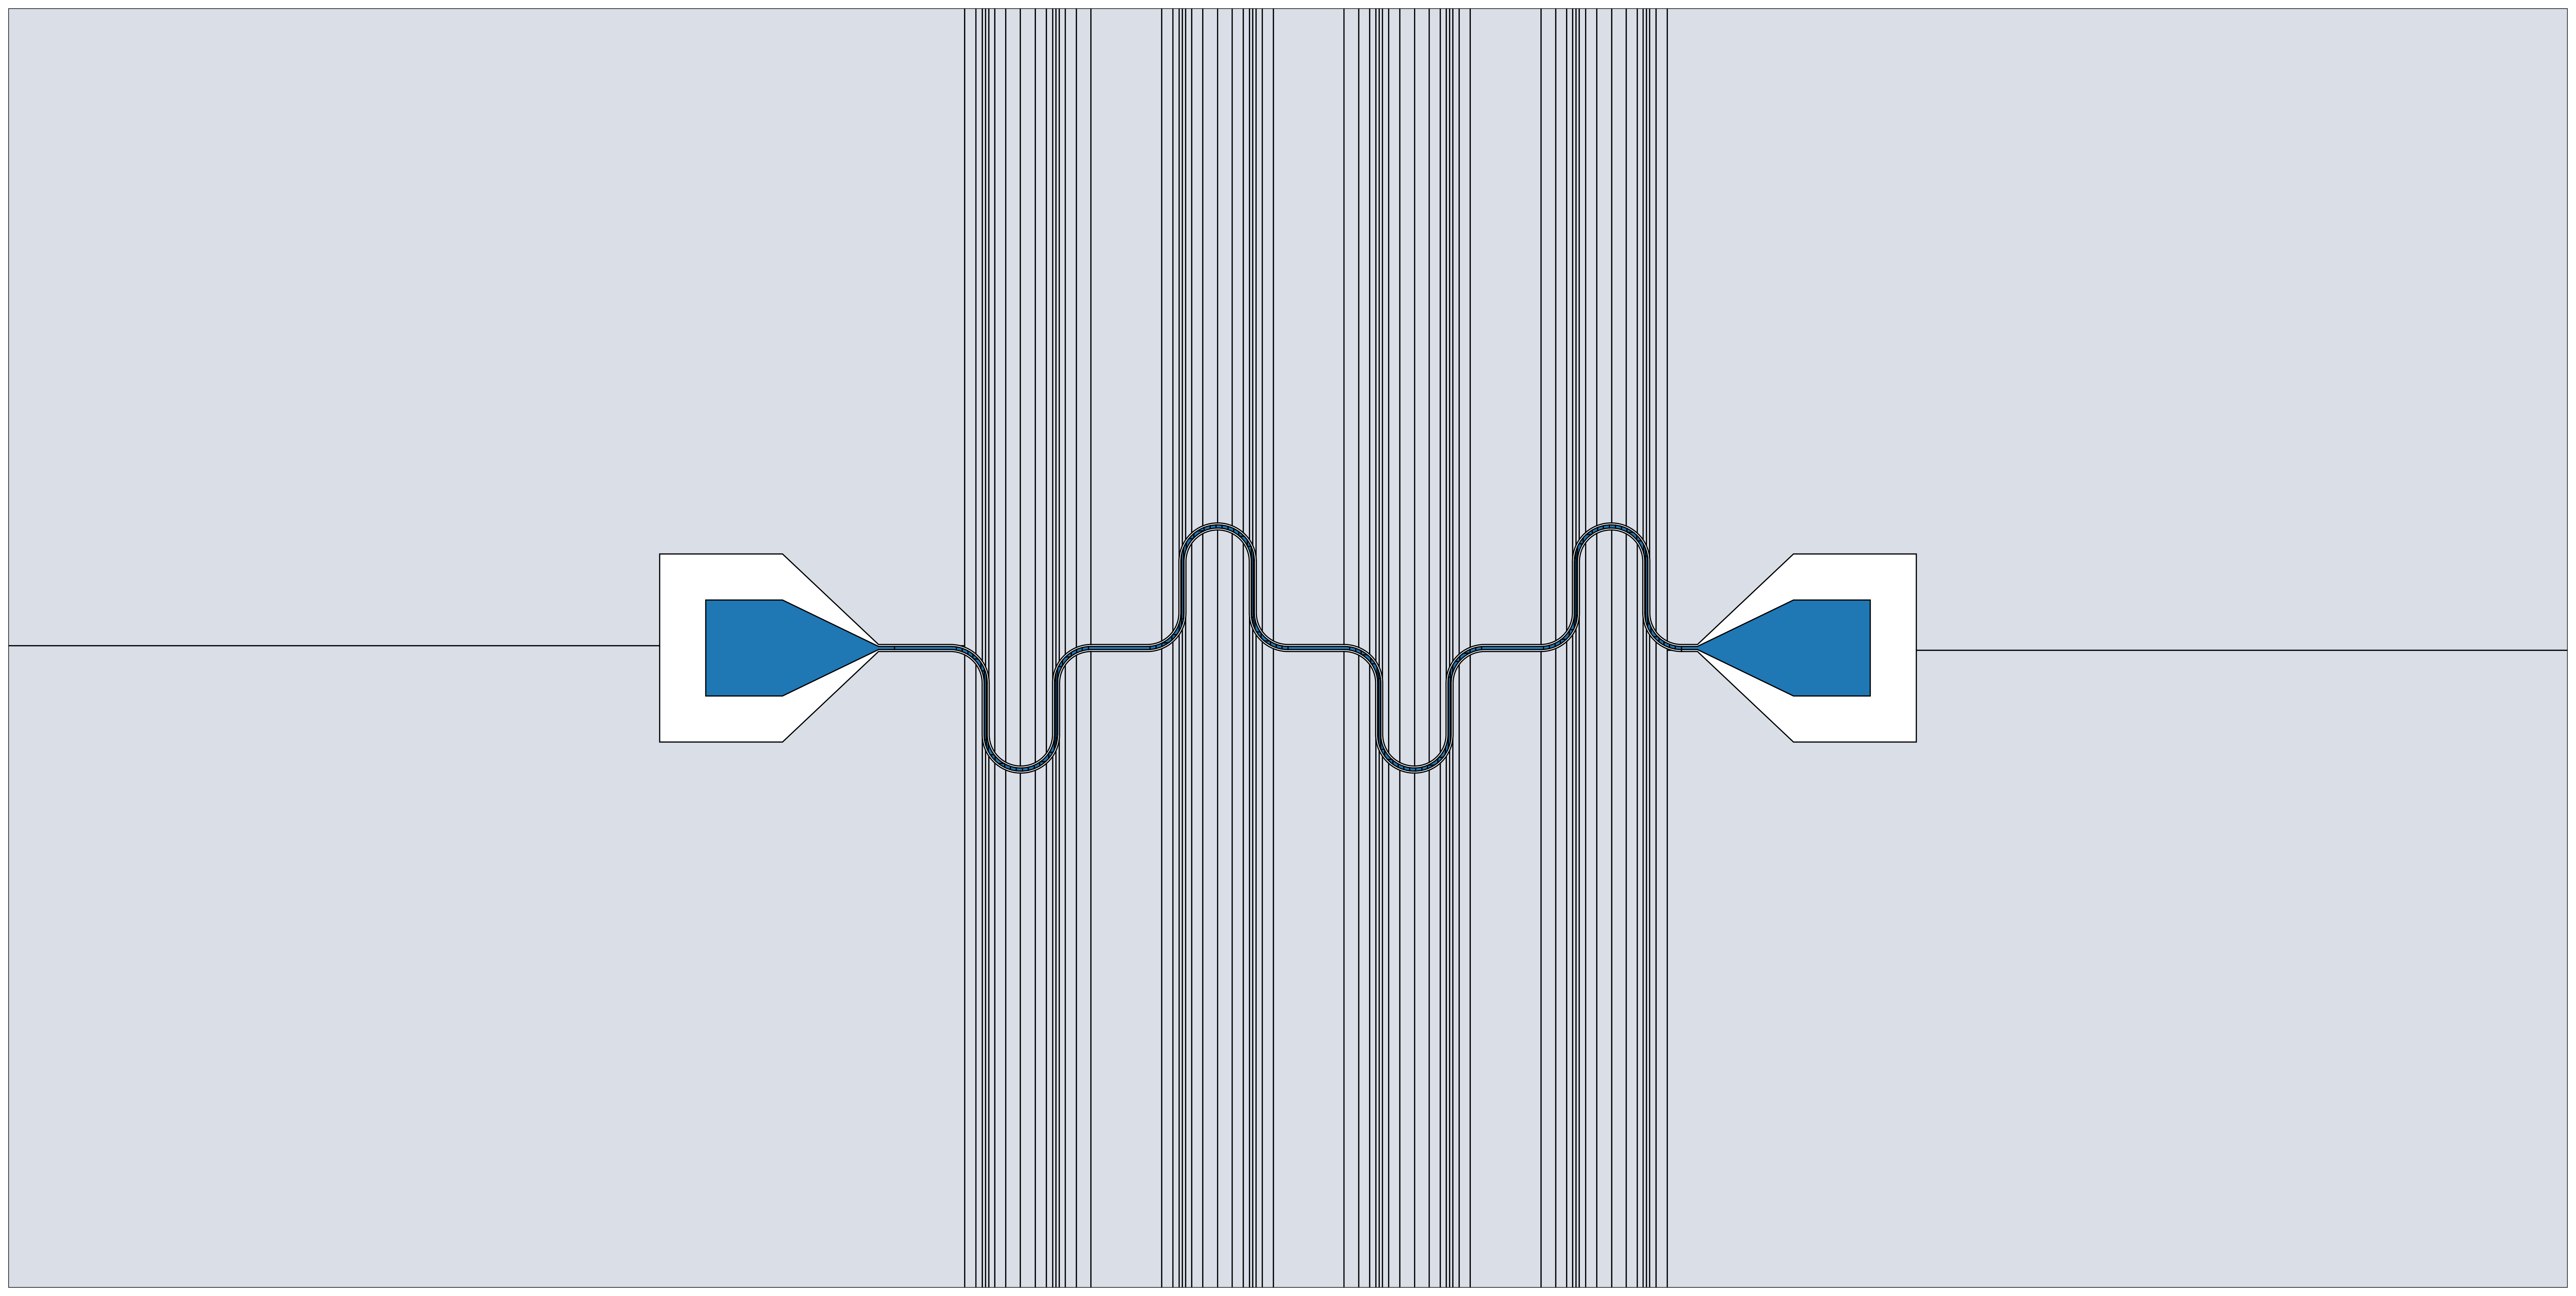

In [11]:
#@title Preview GDS inline
import os, glob, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from IPython.display import display, Image
import gdstk

# ----- knobs you can tweak -----
GDS_PATH      = globals().get("GDS_OUT", "/content/meander_lobes_and_pads_v2.gds")  # reuse if set
TOP_CELL_NAME = globals().get("GDS_TOP_CELL", None)                                  # reuse if set
DPI           = 1200
FIG_WIDTH_IN  = 8.0
LINEWIDTH_PT  = 0.20
BG_COLOR      = "white"

# Layer colors (extend as needed)
LAYER_GROUND  = 2
LAYER_METAL   = 1
LAYER_COLOR   = {LAYER_GROUND: "#d9dee7", LAYER_METAL: "#1f77b4"}

def _pick_cell(lib, name=None):
    if name and name in [c.name for c in lib.cells]:
        print(f"[info] Using requested cell: {name}")
        return lib[name]
    tops = lib.top_level()
    if not tops:
        raise RuntimeError("No top-level cells in library.")
    print(f"[info] Auto-picked top cell: {tops[0].name}")
    return tops[0]

def _polys_by_layer(cell):
    # include_paths=True expands PATHs to polygons; apply_repetitions=True follows array/repetition
    polys = cell.get_polygons(apply_repetitions=True, include_paths=True, depth=None)
    by_layer, xs, ys = {}, [], []
    for p in polys:  # gdstk.Polygon objects
        layer = int(getattr(p, "layer", 0))
        pts = np.asarray(p.points, dtype=float)
        by_layer.setdefault(layer, []).append(pts)
        xs.append(pts[:, 0]); ys.append(pts[:, 1])
    if not xs:
        raise RuntimeError("Found no polygons to plot (empty cell?).")
    xs = np.concatenate(xs); ys = np.concatenate(ys)
    return by_layer, (float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max()))

def save_and_show(gds_path, top_cell_name=None, dpi=DPI, fig_w_in=FIG_WIDTH_IN, lw_pt=LINEWIDTH_PT):
    if not os.path.exists(gds_path):
        # try last written .gds in /content
        cand = sorted(glob.glob("/content/*.gds"), key=os.path.getmtime)[-1:] or []
        if not cand:
            raise FileNotFoundError(f"GDS not found: {gds_path}")
        print(f"[warn] {gds_path} not found. Using most recent: {cand[0]}")
        gds_path = cand[0]

    print(f"[load] Reading: {gds_path}")
    lib  = gdstk.read_gds(gds_path)                                   # loads the library
    cell = _pick_cell(lib, top_cell_name)                              # choose cell
    by_layer, (minx, miny, maxx, maxy) = _polys_by_layer(cell)         # collect polys + bounds
    print(f"[info] Bounds (µm): x[{minx:.3f}, {maxx:.3f}], y[{miny:.3f}, {maxy:.3f}]")

    w_um = maxx - minx; h_um = maxy - miny
    aspect = w_um / max(h_um, 1e-12); fig_h_in = fig_w_in / aspect

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_facecolor(BG_COLOR); ax.axis("off")

    # Draw ground first, then metal, then others for determinism
    draw_order = sorted(by_layer.keys(), key=lambda L: (L != LAYER_GROUND, L))
    for layer in draw_order:
        face = LAYER_COLOR.get(layer, "#666666")
        for pts in by_layer[layer]:
            ax.add_patch(MplPolygon(pts, closed=True, facecolor=face, edgecolor="black",
                                    linewidth=lw_pt, antialiased=True))

    root, _ = os.path.splitext(gds_path)
    out_png = f"{root}_preview_{dpi}dpi.png"
    out_pdf = f"{root}_preview.pdf"

    # Ensure renderer computes extents before saving
    fig.canvas.draw()
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight", pad_inches=0.02)  # 600-DPI PNG
    fig.savefig(out_pdf,            bbox_inches="tight", pad_inches=0.02)  # vector PDF
    print(f"[ok] wrote PNG: {out_png}")
    print(f"[ok] wrote PDF: {out_pdf}")

    # Show inline in the notebook (forces frontend display)
    display(Image(filename=out_png))
    return out_png, out_pdf

png_path, pdf_path = save_and_show(GDS_PATH, top_cell_name=TOP_CELL_NAME)
